In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime
from math import sqrt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    import tensorflow as tf
except:
    !pip install --upgrade tensorflow
    !pip install keras
    !pip install --ignore-installed --upgrade tensorflow-gpu
    !pip install wrapt==1.11.1
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    import tensorflow as tf

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf

In [5]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [6]:
import yfinance as yf
from datetime import datetime

def collect_data(symbol, start_date):
    end_date = datetime.now().strftime('%Y-%m-%d')
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

# Test the function
df = collect_data('AAPL', '2014-01-01')
print(type(df))


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>


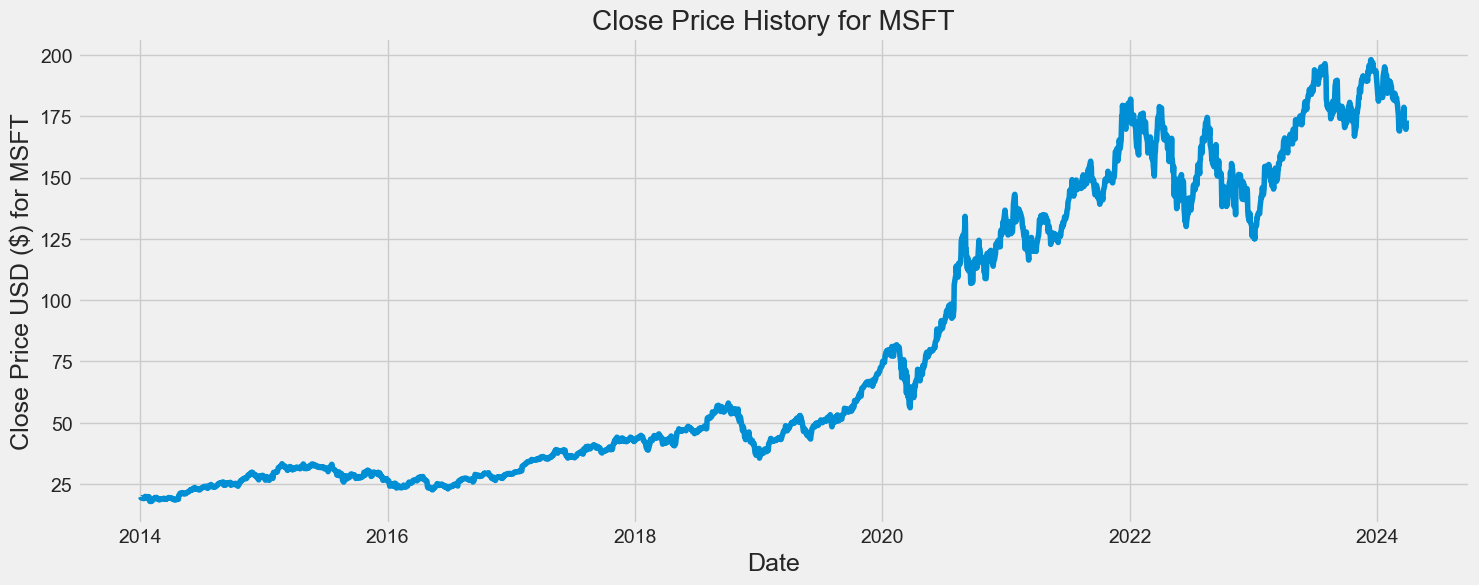

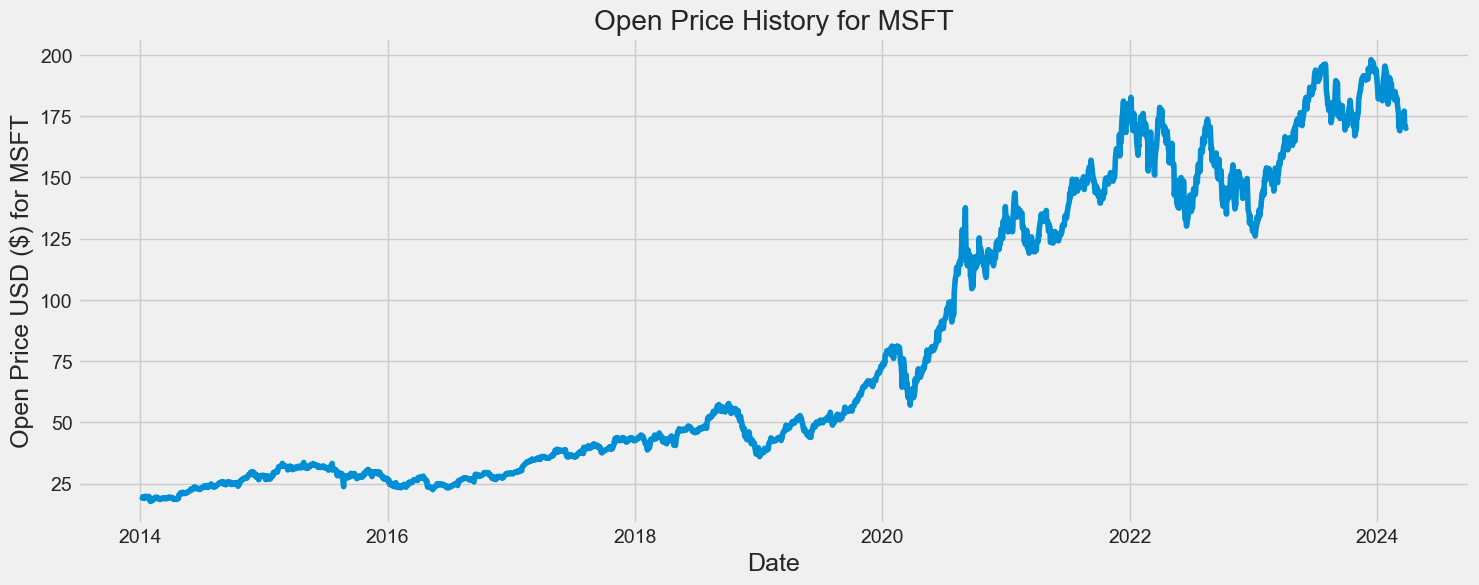

In [7]:
def plot_close_val(data_frame, column, stock):
    plt.figure(figsize=(16,6))
    plt.title(column + ' Price History for ' + stock )
    plt.plot(data_frame[column])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(column + ' Price USD ($) for ' + stock, fontsize=18)
    plt.show()

#Test the function
plot_close_val(df, 'Close', 'MSFT')
plot_close_val(df, 'Open',  'MSFT')

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [9]:
df['Returns'] = (df['Close']/df['Close'].shift(1))-1

# Drop the NaN values created by the percentage change
df = df.dropna()

# Display the updated dataset with the 'Returns' column
print(df.head())

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2014-01-03  19.745001  19.775000  19.301071  19.320715  16.916725  392467600   
2014-01-06  19.194643  19.528570  19.057142  19.426071  17.008976  412610800   
2014-01-07  19.440001  19.498571  19.211430  19.287144  16.887333  317209200   
2014-01-08  19.243214  19.484285  19.238930  19.409286  16.994272  258529600   
2014-01-09  19.528570  19.530714  19.119642  19.161428  16.777248  279148800   

             Returns  
Date                  
2014-01-03 -0.021966  
2014-01-06  0.005453  
2014-01-07 -0.007152  
2014-01-08  0.006333  
2014-01-09 -0.012770  


In [10]:
features = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns']]


In [11]:
scalar=StandardScaler()
scalar.fit(features)


StandardScaler()

In [12]:
scaled_data=scalar.transform(features)

In [13]:
pca=PCA(n_components=1)

In [14]:
pca.fit(scaled_data)

PCA(n_components=1)

In [15]:
x_pca=pca.transform(scaled_data)

In [16]:
x_pca.shape

(2575, 1)

In [17]:
x_pca

array([[ 3.06683599],
       [ 3.13071869],
       [ 2.84075701],
       ...,
       [-3.63910329],
       [-3.60573813],
       [-3.67779962]])

In [18]:
pca_columns = ['Principal_Component']  # Customize column names if needed
x_pca_df = pd.DataFrame(x_pca, columns=pca_columns)
print(x_pca_df.head())

   Principal_Component
0             3.066836
1             3.130719
2             2.840757
3             2.659598
4             2.727048


In [19]:
def build_training_dataset(input_ds):
    # Create a new dataframe with only the 'Close column 
    input_ds.reset_index()
    data = input_ds.filter(items=['Close'])
    # Convert the dataframe to a numpy array
    dataset = data.values
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    return data, dataset, training_data_len

#Test the function
training_data_df, training_dataset_np, training_data_len = build_training_dataset(df)
dataset=training_dataset_np
data=training_data_df

In [20]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
def scale_the_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return scaler, scaled_data

#Test the function
scaler, scaled_data = scale_the_data(training_dataset_np)

In [21]:
def build_training_dataset_pca(input_ds):
    # Create a new dataframe with only the 'Close column 
    input_ds.reset_index()
    data_pca = input_ds.filter(items=['Principal_Component'])
    # Convert the dataframe to a numpy array
    dataset_pca = data.values
    # Get the number of rows to train the model on
    training_pca_data_len = int(np.ceil( len(dataset) * .95 ))
    return dataset_pca, training_pca_data_len

#Test the function
training_pca_dataset_np, training_pca_data_len = build_training_dataset_pca(x_pca_df)

In [22]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
def scale_the_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return scaler, scaled_data

#Test the function
scaler_pca, scaled_data_pca = scale_the_data(training_pca_dataset_np)

In [23]:
# Import ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Function to build ARIMA training dataset
def build_arima_training_dataset(dataset):
    return dataset.flatten()

# Test the function
arima_training_dataset = build_arima_training_dataset(training_pca_dataset_np)

# Function to scale the ARIMA training dataset
def scale_arima_data(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset.reshape(-1, 1))
    return scaler, scaled_data.flatten()

# Test the function
scaler_arima, scaled_arima_data = scale_arima_data(arima_training_dataset)


In [24]:
from statsmodels.tsa.arima.model import ARIMA

# Function to build and train ARIMA model
def build_arima_model(dataset):
    # Fit ARIMA model
    arima_model = ARIMA(dataset, order=(5,1,0)) # Example order, you might need to tune it
    arima_model_fit = arima_model.fit()
    return arima_model_fit

# Test the function
arima_model_fit = build_arima_model(scaled_arima_data)


In [25]:
# Function to create testing dataset and make predictions using ARIMA model
def create_arima_predictions(arima_model_fit, scaler, scaled_data, training_data_len, test_data_len):
    # Get the scaled test data
    test_data = scaled_data[-test_data_len:].reshape(-1, 1)

    # Make predictions
    predictions = arima_model_fit.forecast(steps=test_data_len)

    # Inverse scale the predictions
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Get the root mean squared error (RMSE)
    y_test = scaler.inverse_transform(test_data).flatten()

    rmse = np.sqrt(np.mean((predictions - y_test) ** 2))

    return predictions, y_test, rmse

# Test the function
TEST_DATA_LENGTH = 100
predictions_arima, y_test_arima, rmse_arima = create_arima_predictions(arima_model_fit, scaler_arima, scaled_arima_data, training_data_len, TEST_DATA_LENGTH)


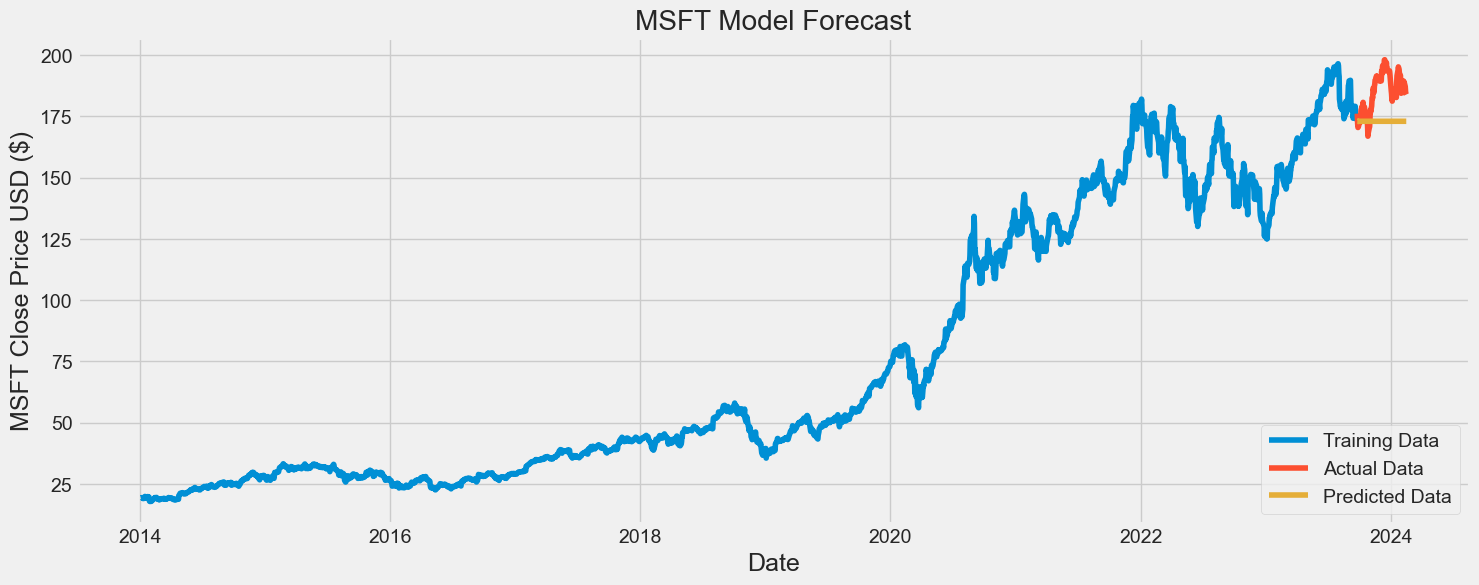

,Close,Predictions
Date,,
2023-09-25,176.080002,173.017602
2023-09-26,171.960007,173.015379
2023-09-27,170.429993,172.955167
2023-09-28,170.690002,172.871693
2023-09-29,171.210007,172.987174
...,...,...
2024-02-09,188.850006,172.975015
2024-02-12,187.149994,172.975015
2024-02-13,185.039993,172.975015


In [26]:
import matplotlib.pyplot as plt

def plot_predictions_arima(stock, data, predictions, y_test, training_data_len):
    # Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:training_data_len+len(y_test)]
    valid['Predictions'] = predictions
    
    # Visualize the data
    plt.figure(figsize=(16, 6))
    plt.title(stock + ' Model Forecast')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(stock + ' Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Training Data', 'Actual Data', 'Predicted Data'], loc='lower right')
    plt.show()
    return valid

# Test the function
plot_predictions_arima('MSFT', data, predictions_arima, y_test_arima, training_data_len)


In [33]:
# Calculate RMSE for training and test sets
def calculate_rmse(predictions, actual):
    if len(actual) == 0:
        return None
    return np.sqrt(mean_squared_error(predictions, actual))
train_predictions = predictions_arima[:training_data_len]
train_actual = y_test_arima[:training_data_len]
test_predictions = predictions_arima[training_data_len:]
test_actual = y_test_arima[training_data_len:]
# Calculate RMSE for training set
train_rmse = calculate_rmse(train_predictions, train_actual)

if train_rmse is not None:
    print("RMSE for training set:", train_rmse)
else:
    print("Not enough training data available to calculate RMSE.")

# Calculate RMSE for test set
test_rmse = calculate_rmse(test_predictions, test_actual)
if test_rmse is not None:
    print("RMSE for test set:", test_rmse)
else:
    print("Not enough test data available to calculate RMSE.")


RMSE for training set: 14.613187230284613
Not enough test data available to calculate RMSE.
